In [1]:
# A décommenter à la première exécution si jupyter se plaint de ne pas trouver oracledb
# !pip install --upgrade oracledb
# !pip install --upgrade folium

Login :  KLENTZ
Mot de passe :  ········


Identifiant de l’hôte : 25
Nombre total d'athlètes participants :
[10832]

Tableau répartition par genre :
    GENRE  Nombre
0    Male    8516
1  Female    5525

Tableau répartition par pays :
   NOC  Nombre
0  AUS     803
1  USA     781
2  RUS     606
3  GER     578
4  FRA     473
   IDATHLETE PRENOMATHLETE            NOMATHLETE  GOLD  SILVER  BRONZE  TOTAL
0      30978       Aleksey                 Nemov     2       1       2      5
1      13253      Leontien  Zijlaard-van Moorsel     3       1       0      4
2      49315          Inge             de Bruijn     3       0       0      3
3      93833          Yana             Klochkova     2       1       0      3
4      49500        Pieter    van den Hoogenband     2       0       1      3
5      48575         Massi              Rosolino     1       1       1      3
6      51218          Dara                Torres     0       0       3      3
7      13061       Félicia             Ballanger     2       0       0      2
8      50965   

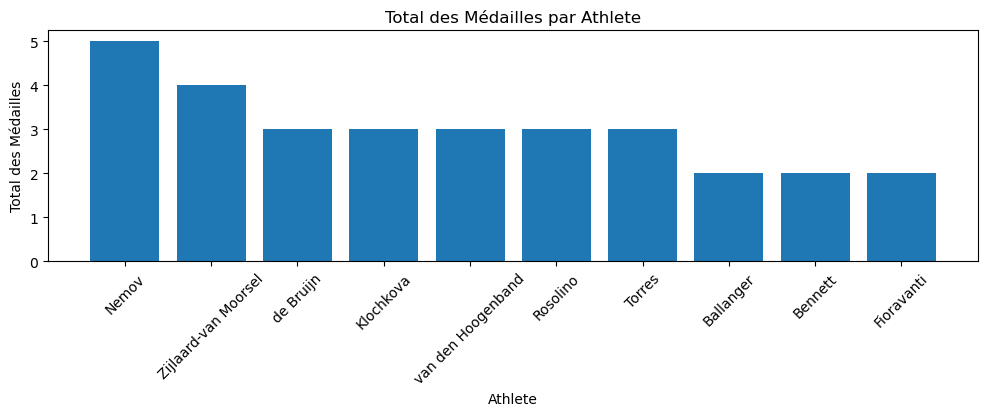

   NOC  GOLD  SILVER  BRONZE  TOTAL
0  RUS    24      23      25     72
1  USA    24      17      24     65
2  CHN    21      10      12     43
3  GER     6      14      14     34
4  AUS     7      15      10     32
5  FRA     9      11       8     28
6  CUB    10       9       5     24
7  ITA     9       5       9     23
8  KOR     6       8       7     21
9  GBR     9       5       5     19


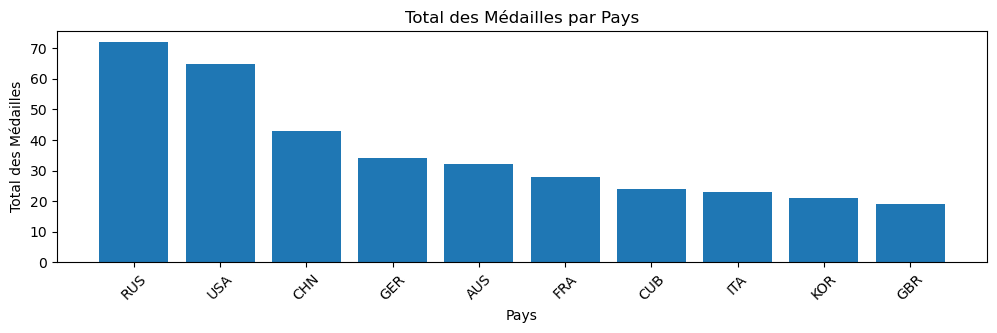

   IDATHLETE PRENOMATHLETE         NOMATHLETE  GOLD  SILVER  BRONZE  TOTAL
0      51217         Jenny           Thompson     3       0       0      3
1      45230       Michael               Klim     2       1       0      3
2      93280           Ian             Thorpe     2       1       0      3
3      50021          Olga         Brusnikina     2       0       0      2
4      92674      Georgeta  Damian-Andrunache     2       0       0      2
5       9879        Birgit    Fischer-Schmidt     2       0       0      2
6      39501         Doina              Ignat     2       0       0      2
7      10072        Zoltán           Kammerer     2       0       0      2
8      50025        Mariya          Kiselyova     2       0       0      2
9      93273          Todd            Pearson     2       0       0      2


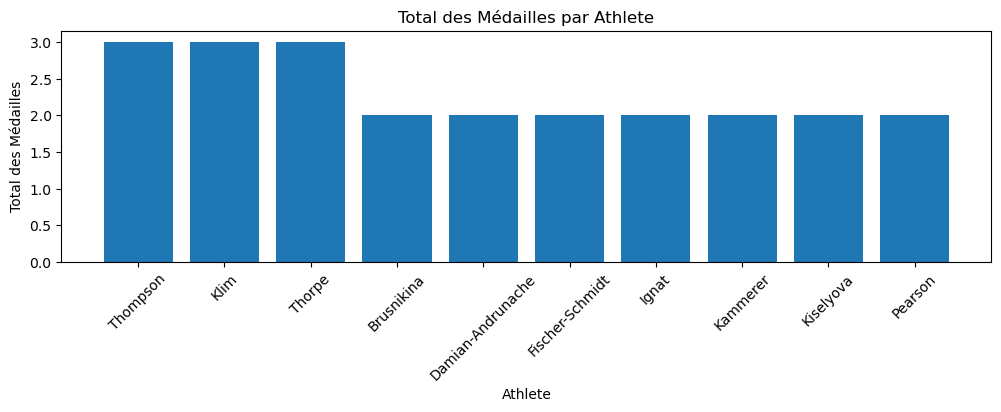

   NOC  GOLD  SILVER  BRONZE  TOTAL
0  USA    13       7       8     28
1  AUS     9      10       7     26
2  GER     7       3      12     22
3  RUS     8       5       4     17
4  CHN     7       6       2     15
5  ITA     4       3       4     11
6  FRA     4       3       3     10
7  GBR     2       5       2      9
8  NED     1       6       2      9
9  BRA     0       3       6      9


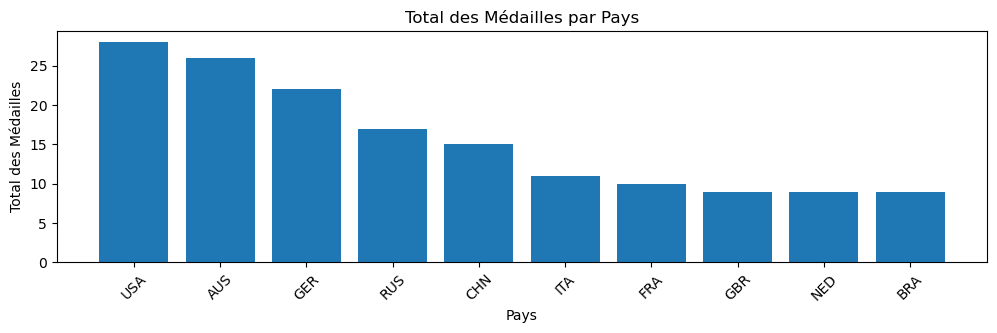

In [421]:
# Compléter ici les imports dont vous avez besoin, ne pas modifier ceux déjà présents
## A EXECUTER EN PREMIER POUR SE CONNECTER A ORACLE
import getpass
from os import getenv
import pandas as pd
import oracledb
import warnings
import matplotlib.pyplot as plt
import folium
import requests
from bs4 import BeautifulSoup
import re
%run tableau_de_bord_ete.ipynb
import numpy as np
from IPython.display import HTML

# Présentation générale de l'édition des JO qui vous a été assignée

### Récupérer les coordonnées des lieux et les mettres sur une carte

In [236]:
# coordonnées de la ville hote
sydney_coords = [-33.8688, 151.2093]
# Créer une carte centrée sur l'australie 
australia_map = folium.Map(location=sydney_coords, zoom_start=5, width=1200, height=250)

# Ajouter un marqueur pour Sydney
folium.Marker(location=sydney_coords, popup='Sydney').add_to(australia_map)
# Définir l'URL pour les épreuves olympiques
url = 'https://www.olympedia.org/venues/editions/25'

# Récupérer le contenu de la page
request = requests.get(url)    
# récupérer le code HTML de la page
codeHTML = BeautifulSoup(request.text, 'html')  
# rechercher la table contenant les épreuve
codeHTML = codeHTML.find('table', class_='table table-striped')   
# ne garder que les lignes contenant un lien vers un lieu
table = codeHTML.find_all('a', href=lambda href: href and '/venues/7' in href)    
# Extraire le href et le nom du lieu
table = [{'href': lien['href'], 'nom': lien.text} for lien in table]

# placer marqueur pour chaque épreuve sur la carte de l'australie
url_lieu = "https://www.olympedia.org"
marker_table = []
for lien in table :
    # lien de la page de l'épreuve
    url_lieu_modif = url_lieu + lien['href']
    # récupere le contenu de la page
    request = requests.get(url_lieu_modif)    
    # récuperer le code HTML de la page
    codeHTML = BeautifulSoup(request.text, 'html')
    # rechercher les lignes contenant les coordonnées de l'épreuve
    coordonnee = codeHTML.find(string=re.compile("(Definitely here)"))
    pattern = r'(-?\d+\.\d+),\s*(-?\d+\.\d+)'
    matches = re.search(pattern, coordonnee)
    # extraire la lattitude et la longitude
    latitude = matches.group(1)
    longitude = matches.group(2)
    coords = [latitude, longitude]
    # ajouter un point sur la carte avec les coordonnées de l'épreuve
    folium.Marker(location=coords).add_to(australia_map)
# afficher la carte des épreuves 
display(HTML(f"<b><font size='+2'>Carte des épreuves des Jeux Olympique d'été 2000</font></b>"))
print(" ")
australia_map

In [237]:
# Calculer avec une requête et afficher les épreuves nouvellement ajoutée à cette édition
nvlleEpreuve  = requete_vers_dataframe(conn, f"""SELECT DISTINCT nomDiscipline FROM {SCHEMA}.DISCIPLINE
NATURAL JOIN {SCHEMA}.EVENEMENT
WHERE idHote = {id_hote} AND nomDiscipline NOT IN (SELECT nomDiscipline FROM {SCHEMA}.DISCIPLINE
                                            NATURAL JOIN {SCHEMA}.EVENEMENT
                                            WHERE idHote = {id_hote}-1)""")

display(HTML(f"<b><font size='+2'>Épreuves nouvellement ajoutées à cette édition</font></b>"))
print(" ")
display(nvlleEpreuve)

,NOMDISCIPLINE
0,Triathlon
1,Trampolining
2,Taekwondo


In [422]:
# recupere les idHote de tout les Jeux Olympique d'été qui n'ont pas été annulés
hoteSummer  = requete_vers_dataframe(conn, f"""SELECT idHote, anneeHote FROM {SCHEMA}.HOTE
WHERE Saison ='Summer' AND DATESCOMPETITION != '—'""")

In [423]:
# Calculer avec une requête et afficher le nombre d'épreuve de chaque genre 
resultats = []
# pour chaque Jeux Olympique d'été :
for i in range (len(hoteSummer)) :
    # récupere l'année et l'idHote 
    idHote = hoteSummer.loc[i, 'IDHOTE']
    anneeHote = hoteSummer.loc[i, 'ANNEEHOTE']
    # requete pour afficher les épreuves femmes
    genreEpreuveWomen  = requete_vers_dataframe(conn, f"""SELECT DISTINCT NomDiscipline, nomEvenement FROM {SCHEMA}.EVENEMENT E
    NATURAL JOIN {SCHEMA}.DISCIPLINE
    WHERE idHote = {idHote} AND nomEvenement LIKE '%Women%'""")
    # requete pour afficher les épreuves hommes
    genreEpreuveMen  = requete_vers_dataframe(conn, f"""SELECT DISTINCT NomDiscipline, nomEvenement FROM {SCHEMA}.EVENEMENT E
    NATURAL JOIN {SCHEMA}.DISCIPLINE
    WHERE idHote = {idHote} AND nomEvenement LIKE '%Men%'""")
    # calculer le nombre d'épreuve de chaque genre
    nbWomen = genreEpreuveWomen['NOMDISCIPLINE'].count()
    nbMen = genreEpreuveMen['NOMDISCIPLINE'].count()
    # Ajouter les résultats au dictionnaire résultat
    resultats.append({'ANNEEHOTE': anneeHote, 'NBMEN': nbMen, 'NBWOMEN': nbWomen})

# transformer le dictionnarie en dataframe pour l'affichage
df_resultats = pd.DataFrame(resultats)

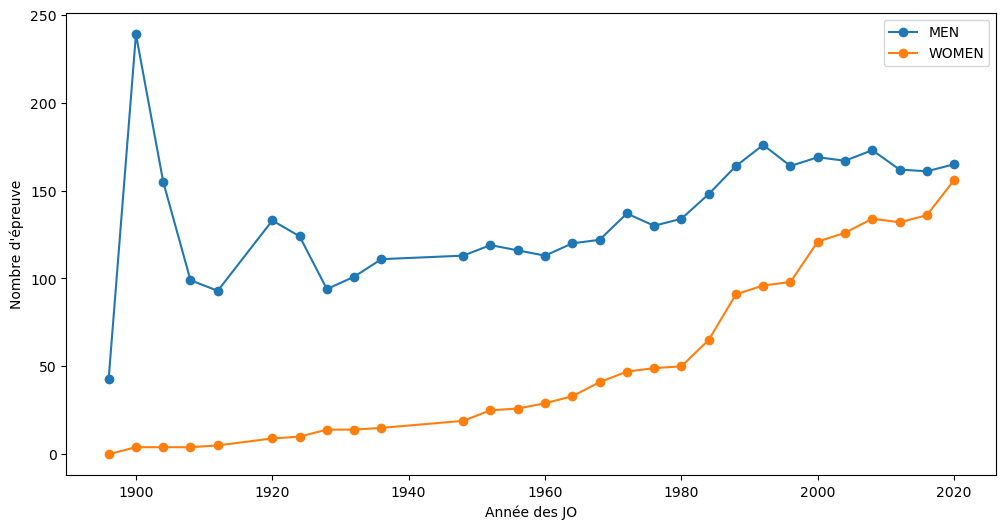

In [274]:
# Définir la taille de la figure
plt.figure(figsize=(12, 6))  
# Tracer MEN
plt.plot(df_resultats.ANNEEHOTE, df_resultats['NBMEN'], marker='o', linestyle='-', label='MEN')
# Tracer WOMEN
plt.plot(df_resultats.ANNEEHOTE, df_resultats['NBWOMEN'], marker='o', linestyle='-', label='WOMEN')

# Ajouter des légendes et titre
display(HTML(f"<b><font size='+2'>Évolution du nombre d'épreuve par genre</font></b>"))
print(" ")
plt.xlabel('Année des JO')
plt.ylabel("Nombre d'épreuve")
display(plt.legend())

# Comparaison de cette édition avec les éditions qui l'ont précédée

### classement des nations (tableau de classement pour les trois couleurs de médailles et pour le total) + répartition des médailles par couleur et par pays.

In [280]:
display(HTML(f"<b><font size='+2'>Classement des nations par médailles durant les {EDITION_JO}</font></b>"))
print(" ")

# création d'un classement global avec les médailles collectives et individuelle
clasementNocGlobal = pd.merge(classementNocEquipe, classementNocIndividuel, on='NOC')
# fusion des colones pour aditionner les médaillles
clasementNocGlobal['GOLD'] = clasementNocGlobal['GOLD_x'] + clasementNocGlobal['GOLD_y']
clasementNocGlobal['SILVER'] = clasementNocGlobal['SILVER_x'] + clasementNocGlobal['SILVER_y']
clasementNocGlobal['BRONZE'] = clasementNocGlobal['BRONZE_x'] + clasementNocGlobal['BRONZE_y']
clasementNocGlobal['TOTAL'] = clasementNocGlobal['TOTAL_x'] + clasementNocGlobal['TOTAL_y']
# trier le dataframe par le total de médailles
clasementNocGlobal = clasementNocGlobal[['NOC', 'GOLD', 'SILVER', 'BRONZE', 'TOTAL']].sort_values(by=['TOTAL'], ascending=False)
# afficher le dataframe
display(clasementNocGlobal)

,NOC,GOLD,SILVER,BRONZE,TOTAL
0,USA,37,24,32,93
3,RUS,32,28,29,89
4,CHN,28,16,14,58
1,AUS,16,25,17,58
2,GER,13,17,26,56
...,...,...,...,...,...
67,LUX,0,0,0,0
68,MAD,0,0,0,0
70,MAS,0,0,0,0
72,MRI,0,0,0,0


### répartition des médailles par genre et par pays, comparaison à l'aide de la moyenne/écart-type et min/max/quartiles/médiane.

### répartition des médailles par continent (Amérique, Europe, Asie, Afrique, Océanie), comparaison là aussi avec les outils vus en statistiques. [Bonus]

In [ ]:
# Créer une nouvelle table continent

### autres idées de répartitions pertinentes [Bonus]

### évolution de ces classements par rapport à l'édition précédente [Bonus]

In [319]:
### évolution à long terme pour le top 3 de cette édition (c'est-à-dire que pour les trois meilleurs pays de cette édition, on veut savoir quelle était leur performance sur les jeux de même type (jeux d'été ou jeux d'hiver) lors des éditions qui ont précédé).

# récupere les idHote des 3 pays avec le plus de médailles
idTop3 = [clasementNocGlobal['NOC'].loc[i] for i in range(3)]
# initialisation d'un dataframe 
resultats_top3 = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'NOC', 'TOTAL'])
# pour chaque Jeux Olympique d'été :
for i in range (len(hoteSummer)) :
    # récupere l'année et l'idHote 
    idHote = hoteSummer.loc[i, 'IDHOTE']
    anneeHote = hoteSummer.loc[i, 'ANNEEHOTE']
    # pour chaque pays du TOP3 (USA, GER, AUS)
    for noc in idTop3:
        # requete pour recupérer le nombre de médailles par équipe de {noc} durant {idhote}
        ClassementEquipe = requete_vers_dataframe(conn,f"""SELECT EQ.NOC,
        COUNT(PE.Medaille) AS Total 
        FROM {SCHEMA}.EVENEMENT E 
        INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEvenement = E.idEvenement
        INNER JOIN {SCHEMA}.EQUIPE EQ ON PE.idEquipe = EQ.idEquipe
        WHERE IDHOTE = {idHote}
        GROUP BY EQ.NOC
        HAVING EQ.NOC = '{noc}'""")
        # requete pour recupérer le nombre de médailles en individuelle de {noc} durant {idhote}
        ClassementIndividuelle = requete_vers_dataframe(conn,f"""SELECT idAthlete, COUNT(PI.Medaille) AS Total 
        FROM {SCHEMA}.EVENEMENT E
        INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
        WHERE IDHOTE = {idHote} AND NOC = '{noc}'
        GROUP BY idAthlete""")
        # assigner l'idHote et l'annéeHote à la ligne pour concatener
        ClassementEquipe['IDHOTE'] = idHote
        ClassementEquipe['ANNEEHOTE'] = anneeHote
        # ajouter le total des médailles individuelles au total des médailles en équipe pour avoir le nombre de médaille total
        ClassementEquipe['TOTAL'] += ClassementIndividuelle['TOTAL'].sum()
        # ajouter la ligne dans un dataframe
        resultats_top3 = pd.concat([resultats_top3, ClassementEquipe], ignore_index=True)

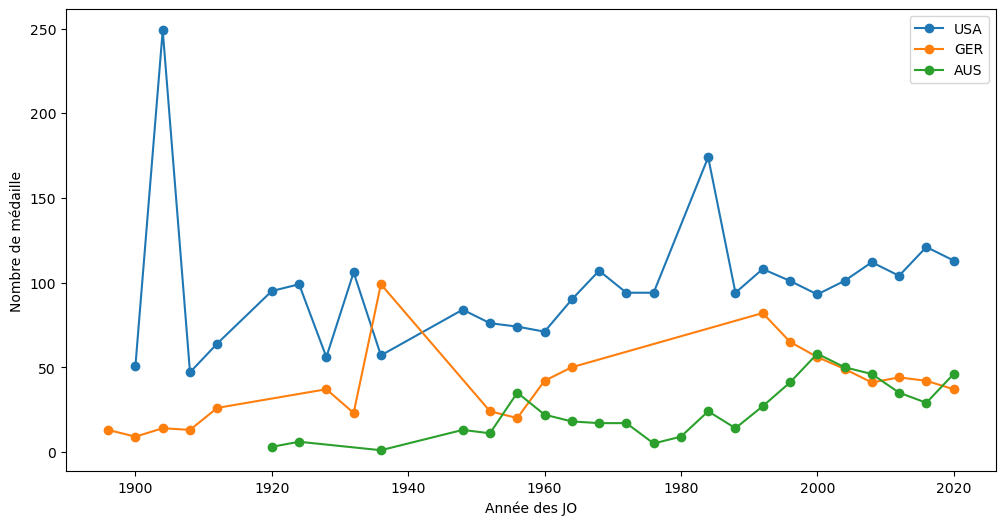

In [330]:
# créer un dataframe pour chaque nation pour afficher les statistique
resultats_top3USA = resultats_top3[resultats_top3['NOC'] == 'USA']
resultats_top3GER = resultats_top3[resultats_top3['NOC'] == 'GER']
resultats_top3AUS = resultats_top3[resultats_top3['NOC'] == 'AUS']

# Tracer les données avec matplotlib
plt.figure(figsize=(12, 6))  # Définir la taille de la figure

# Tracer USA
plt.plot(resultats_top3USA.ANNEEHOTE, resultats_top3USA['TOTAL'], marker='o', linestyle='-', label='USA')
# Tracer GER
plt.plot(resultats_top3GER.ANNEEHOTE, resultats_top3GER['TOTAL'], marker='o', linestyle='-', label='GER')
# Tracer AUS
plt.plot(resultats_top3AUS.ANNEEHOTE, resultats_top3AUS['TOTAL'], marker='o', linestyle='-', label='AUS')

# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('Année des JO')
plt.ylabel('Nombre de médaille')
display(HTML(f"<b><font size='+2'>Évolution du nombre de médaille par nation </font></b>"))
print(" ")
plt.legend()

### tailles des délégations (et tendances à long terme). [Bonus]

In [372]:
## J'AI PAS FAIT LES TENDANCES A LONG TERME
# initialisation d'un dataframe
taille_deleg = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'NOC'])
# pour chaque Jeux Olympique d'été :
for i in range (len(hoteSummer)) :
    # récupere l'année et l'idHote 
    idHote = hoteSummer.loc[i, 'IDHOTE']
    anneeHote = hoteSummer.loc[i, 'ANNEEHOTE']
    # pour chaque pays du TOP3 (USA, GER, AUS)
    for noc in idTop3:
        # requete pour recupérer le nombre d'athlete
        nbAthleteNoc = requete_vers_dataframe(conn, f"""SELECT COUNT(DISTINCT idAthlete) FROM (
        SELECT PI.idAthlete FROM {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI
        INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PI.idEvent
        INNER JOIN {SCHEMA}.HOTE H ON H.idHote = E.idHote
        WHERE H.idHote ={idHote} AND PI.NOC = '{noc}'
        UNION ALL
        SELECT CE.idAthlete FROM COMPOSITION_EQUIPE CE
        INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEquipe = CE.idEquipe
        INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PE.idEvenement
        INNER JOIN {SCHEMA}.EQUIPE EQ ON EQ.idEquipe = PE.idEquipe
        INNER JOIN {SCHEMA}.HOTE H ON H.idHote = E.idHote
        WHERE H.idHote = {idHote} AND EQ.NOC = '{noc}')""")
         # assigner l'idHote, l'annéeHote et noc à la ligne pour concatener 
        nbAthleteNoc['IDHOTE'] = idHote
        nbAthleteNoc['ANNEEHOTE'] = anneeHote
        nbAthleteNoc['NOC'] = noc
        # concatener la ligne 
        taille_deleg = pd.concat([taille_deleg, nbAthleteNoc], ignore_index=True)
# renommer la colonnes count pour plus de clarete
taille_deleg = taille_deleg.rename(columns={'COUNT(DISTINCTIDATHLETE)': 'NBATHLETE'})

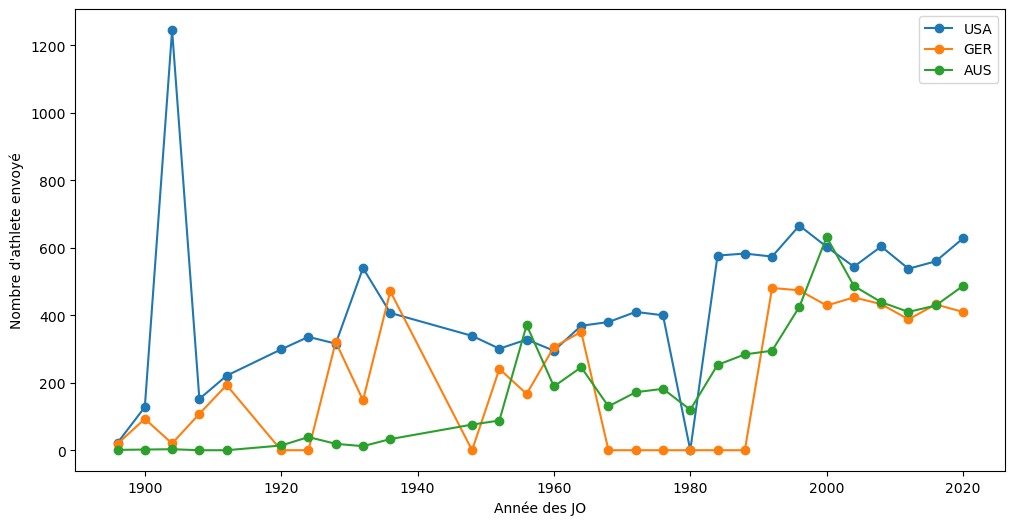

In [385]:
# créer un dataframe pour chaque nation pour afficher les statistique
taille_delegUSA = taille_deleg[taille_deleg['NOC'] == 'USA']
taille_delegGER = taille_deleg[taille_deleg['NOC'] == 'GER']
taille_delegAUS = taille_deleg[taille_deleg['NOC'] == 'AUS']
# Tracer les données avec matplotlib
plt.figure(figsize=(12, 6))  # Définir la taille de la figure

# Tracer USA
plt.plot(taille_delegUSA.ANNEEHOTE, taille_delegUSA['NBATHLETE'], marker='o', linestyle='-', label='USA')
# Tracer GER
plt.plot(taille_delegGER.ANNEEHOTE, taille_delegGER['NBATHLETE'], marker='o', linestyle='-', label='GER')
# Tracer AUS
plt.plot(taille_delegAUS.ANNEEHOTE, taille_delegAUS['NBATHLETE'], marker='o', linestyle='-', label='AUS')

# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('Année des JO')
plt.ylabel("Nombre d'athlete envoyé")
display(HTML(f"<b><font size='+2'>Évolution du nombre d'athlete envoyé par chaque délégation </font></b>"))
print(" ")
plt.legend()

### moyennes d'âge des athlètes (et tendances à long terme).

In [386]:
# PAS FAIT TENDANCE A LONG TERME
# initialisation de dataFrame
moyenneAgeJOMen = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'AGEMOYEN'])
moyenneAgeJOWomen = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'AGEMOYEN'])
moyenneAgeJO = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'AGEMOYEN'])
# pour chaque Jeux Olympique d'été :
for i in range (len(hoteSummer)) :
    # récupere l'année et l'idHote 
    idHote = hoteSummer.loc[i, 'IDHOTE']
    anneeHote = hoteSummer.loc[i, 'ANNEEHOTE']
    # requete pour récuperer l'age moyen des hommes au moment de leurs participations au JO
    ageAthleteMen = requete_vers_dataframe(conn,f"""SELECT DISTINCT idAthlete,  
    (ANNEEHOTE - EXTRACT(YEAR FROM DATENAISSANCE)) AS AGECOMPET FROM {SCHEMA}.ATHLETE 
    NATURAL JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI
    INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PI.idEvent
    NATURAL JOIN {SCHEMA}.HOTE
    WHERE DateDeces IS NULL AND DATENAISSANCE IS NOT NULL AND idHote = {idHote} AND genre = 'Male'""")
    # requete pour récuperer l'age moyen des femmes au moment de leurs participations au JO
    ageAthleteWomen = requete_vers_dataframe(conn,f"""SELECT DISTINCT idAthlete,  
    (ANNEEHOTE - EXTRACT(YEAR FROM DATENAISSANCE)) AS AGECOMPET FROM {SCHEMA}.ATHLETE 
    NATURAL JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI
    INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PI.idEvent
    NATURAL JOIN {SCHEMA}.HOTE
    WHERE DateDeces IS NULL AND DATENAISSANCE IS NOT NULL AND idHote = {idHote} AND genre = 'Female'""")
    # Supprimer les doublons
    ageAthleteWomen = ageAthleteWomen.drop_duplicates(subset='IDATHLETE')
    ageAthleteMen = ageAthleteMen.drop_duplicates(subset='IDATHLETE')
    # calculer l'age moyen
    ageMoyenMen = ageAthleteMen['AGECOMPET'].mean()
    ageMoyenWomen = ageAthleteWomen['AGECOMPET'].mean()
    # concatener (ajouter ligne à un dataFrame)
    moyenneAgeJOMen = pd.concat([moyenneAgeJOMen, pd.DataFrame({'IDHOTE': [idHote], 'ANNEEHOTE': [anneeHote], 'AGEMOYEN': [ageMoyenMen]})], ignore_index=True)
    moyenneAgeJOWomen = pd.concat([moyenneAgeJOWomen, pd.DataFrame({'IDHOTE': [idHote], 'ANNEEHOTE': [anneeHote], 'AGEMOYEN': [ageMoyenWomen]})], ignore_index=True)

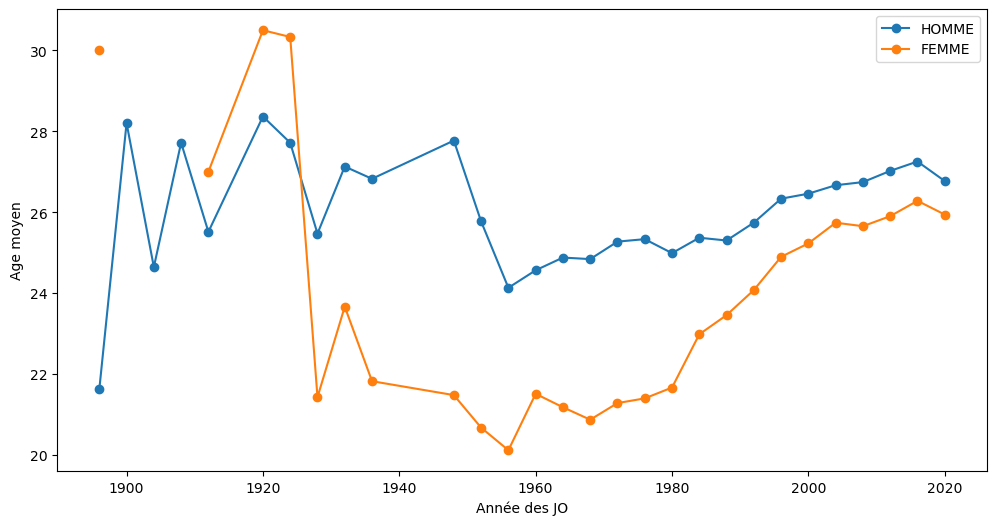

In [387]:
# Définir la taille de la figure
plt.figure(figsize=(12, 6))  

# Tracer HOMME
plt.plot(moyenneAgeJOMen.ANNEEHOTE, moyenneAgeJOMen['AGEMOYEN'], marker='o', linestyle='-', label='HOMME')
# Tracer FEMME
plt.plot(moyenneAgeJOWomen.ANNEEHOTE, moyenneAgeJOWomen['AGEMOYEN'], marker='o', linestyle='-', label='FEMME')

# Ajouter des légendes et titre
plt.xlabel('Année des JO')
plt.ylabel('Age moyen')
display(HTML(f"<b><font size='+2'>Évolution de l'age moyen des athlete par genre </font></b>"))
print(" ")
plt.legend()

### tailles des athlètes (et tendances à long terme). [Bonus]

In [388]:
# requete renvoyant la taille des athletes fessant des sport collectif
tailleMoyenSportCollectifGenre = requete_vers_dataframe(conn, f"""SELECT DISTINCT A.idAthlete, nomSport, taille, Genre FROM {SCHEMA}.ATHLETE A
INNER JOIN {SCHEMA}.COMPOSITION_EQUIPE CE ON CE.idAthlete = A.idAthlete
INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEquipe = CE.idEquipe 
INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PE.idEvenement
INNER JOIN {SCHEMA}.DISCIPLINE D ON D.CodeDiscipline = E.CodeDiscipline
INNER JOIN {SCHEMA}.SPORT S ON S.CodeSport = D.CodeSport""")
# requete renvoyant la taille des athletes fessant des sport individuel 
tailleMoyenSportIndividuelGenre = requete_vers_dataframe(conn, f"""SELECT DISTINCT A.idAthlete, nomSport, taille, Genre FROM {SCHEMA}.ATHLETE A
INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idAthlete = A.idAthlete
INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PI.idEvent
INNER JOIN {SCHEMA}.DISCIPLINE D ON D.CodeDiscipline = E.CodeDiscipline
INNER JOIN {SCHEMA}.SPORT S ON S.codeSport = D.CodeSport""")

In [389]:
# calculer la taille moyenne par sport et par genre
taille_moyenneGenreIndividuelle = tailleMoyenSportIndividuelGenre.groupby(['GENRE', 'NOMSPORT'])['TAILLE'].mean().reset_index()
taille_moyenneGenreEquipe = tailleMoyenSportCollectifGenre.groupby(['GENRE', 'NOMSPORT'])['TAILLE'].mean().reset_index()
# trier par taille décroissante
taille_moyenneGenreEquipe = taille_moyenneGenreEquipe.sort_values(by=['TAILLE'], ascending=False)
taille_moyenneGenreIndividuelle = taille_moyenneGenreIndividuelle.sort_values(by=['TAILLE'], ascending=False)
# Calculer la moyenne de la taille moyenne pour chaque sport
tailleMoyenneSportCollectif = tailleMoyenneSportCollectif_vf.groupby('NOMSPORT')['TAILLE'].mean().reset_index()
tailleMoyenneSportIndividuel = tailleMoyenneSportIndividuel_vf.groupby('NOMSPORT')['TAILLE'].mean().reset_index()
# trier par taille décroissante
tailleMoyenneSportCollectif = tailleMoyenneSportCollectif.sort_values(by=['TAILLE'], ascending=False)
tailleMoyenneSportIndividuel = tailleMoyenneSportIndividuel.sort_values(by=['TAILLE'], ascending=False)

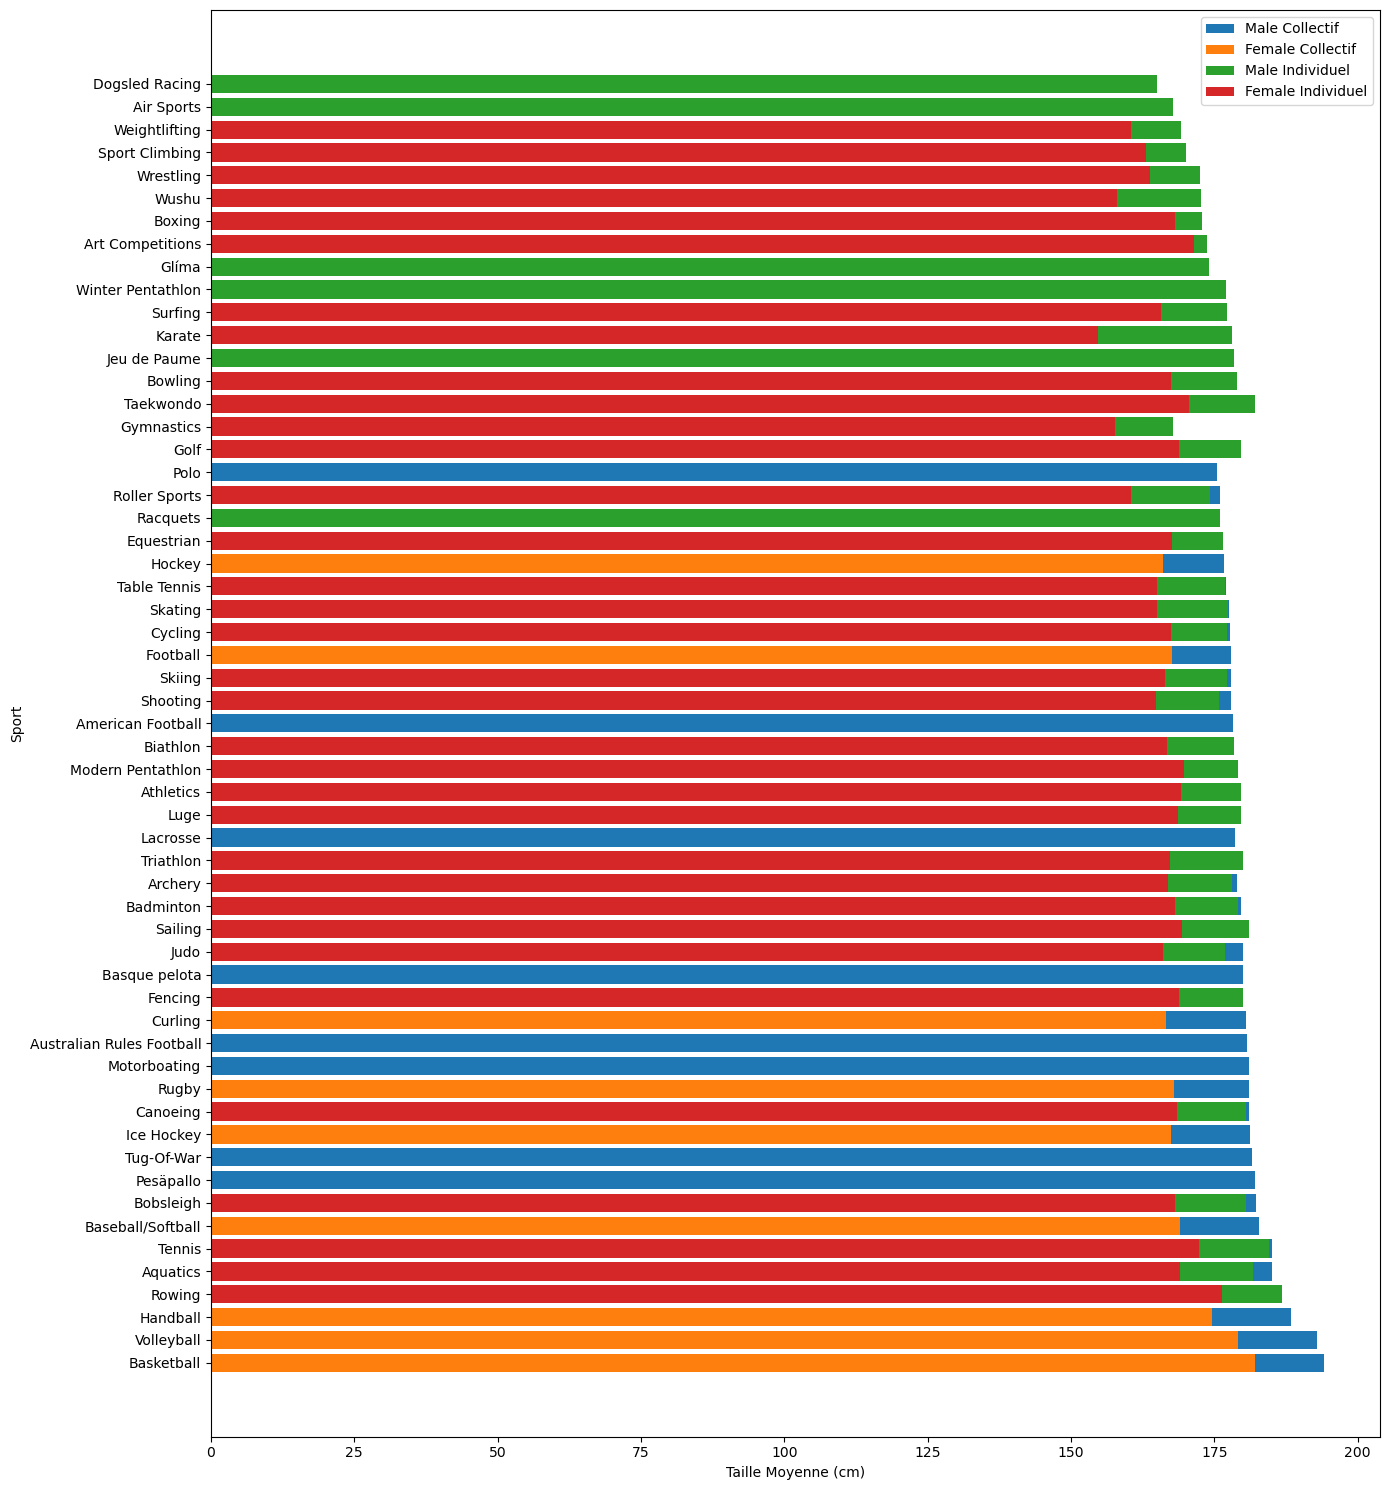

In [391]:
# Création de la figure
plt.figure(figsize=(14, 15))

# Tracer les barres pour les sports collectifs
for genre in taille_moyenneGenreEquipe['GENRE'].unique():
    df = taille_moyenneGenreEquipe[taille_moyenneGenreEquipe['GENRE'] == genre]
    # enlever les sport ou taille est null
    df = df[~np.isnan(df['TAILLE'])]
    # tracer la bare
    plt.barh(df['NOMSPORT'], df['TAILLE'], label=f'{genre} Collectif')

# Tracer les barres pour les sports individuels
for genre in taille_moyenneGenreIndividuelle['GENRE'].unique():
    df = taille_moyenneGenreIndividuelle[taille_moyenneGenreIndividuelle['GENRE'] == genre]
    # enlever les sport ou taille est null
    df = df[~np.isnan(df['TAILLE'])]
    # tracer la bare
    plt.barh(df['NOMSPORT'], df['TAILLE'], label=f'{genre} Individuel')
    
# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('Taille Moyenne (cm)')
plt.ylabel('Sport')
display(HTML(f"<b><font size='+2'>Taille Moyenne des Athlètes par Sport et par Genre </font></b>"))
print(" ")
plt.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()

### féminisation : nombre d'événements féminins, nombre d'athlètes femme (et tendance à long terme).

In [424]:
# Initialisation du DataFrame
df_femme = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'NBEPREUVEFEMME', 'NBFEMME'])
df_femme[['ANNEEHOTE', 'NBEPREUVEFEMME']] = df_resultats[['ANNEEHOTE', 'NBWOMEN']]

# pour chaque Jeux Olympique d'été :
for i in range (len(hoteSummer)) :
    # récupere l'année et l'idHote 
    idHote = hoteSummer.loc[i, 'IDHOTE']
    anneeHote = hoteSummer.loc[i, 'ANNEEHOTE']
    # requete pour récuperer le nombre de femme participant aux épreuves individuelle
    femmeIndividuelle = requete_vers_dataframe(conn, f"""SELECT DISTINCT A.idAthlete FROM ATHLETE A
        INNER JOIN PARTICIPATION_INDIVIDUELLE PI ON PI.idAthlete = A.idAthlete
        INNER JOIN EVENEMENT E ON E.idEvenement = PI.idEvent
        WHERE E.idHote = {idHote}  AND Genre = 'Female'""")
    # requete pour récuperer le nombre de femme participant aux épreuves individuelle
    femmeCollective = requete_vers_dataframe(conn, f"""SELECT A.idAthlete FROM ATHLETE A
        INNER JOIN COMPOSITION_EQUIPE CE ON CE.idAthlete = A.idAthlete
        INNER JOIN PARTICIPATION_EQUIPE PE ON PE.idEquipe = CE.idEquipe
        INNER JOIN EVENEMENT E ON E.idEvenement = PE.idEvenement
        WHERE E.idHote = {idHote} AND Genre = 'Female'""")
    # combiner les deux résultats
    nombreFemme = pd.concat([femmeIndividuelle,femmeCollective]).reset_index(drop=True)
    # suppresion des doublons
    nombreFemme = nombreFemme.drop_duplicates(subset='IDATHLETE')
    nbFemmeCount = nombreFemme.shape[0]
    df_femme.loc[df_femme['ANNEEHOTE'] == anneeHote, 'NBFEMME'] = nbFemmeCount
    df_femme.loc[df_femme['ANNEEHOTE'] == anneeHote, 'IDHOTE'] = idHote

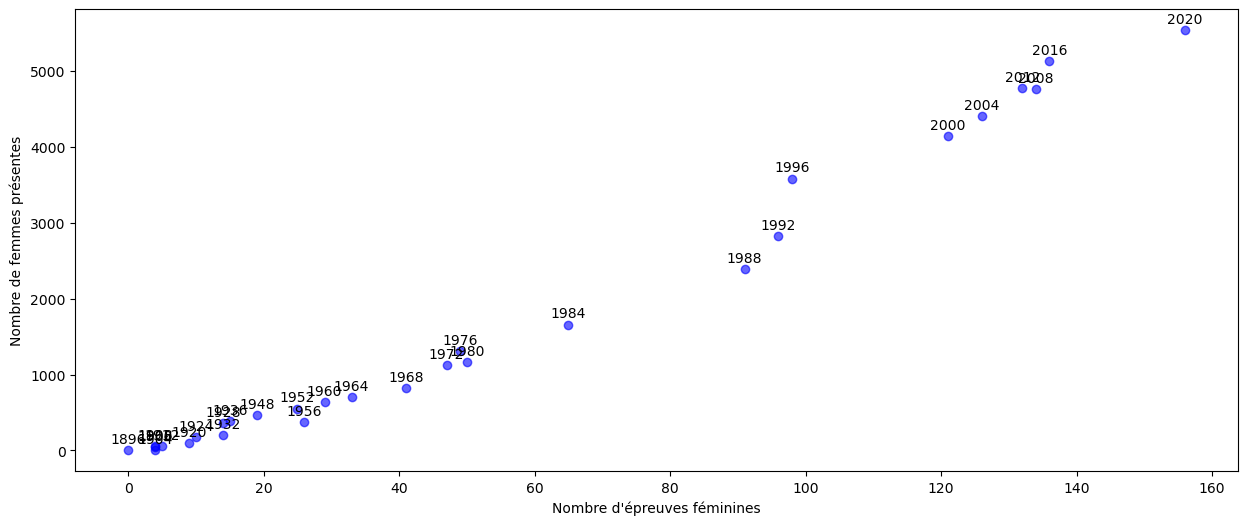

In [449]:
# taille de la figure
plt.figure(figsize=(15, 6))
# initalisation d'un nuage de point avec x: NBEPREUVEFEMME et y : NBFEMME
plt.scatter(df_femme['NBEPREUVEFEMME'], df_femme['NBFEMME'], color='blue', alpha=0.6)
# Ajouter des labels et un titre
display(HTML(f"<b><font size='+2'>Évolution du nombre d'épreuves féminines par rapport au nombre de femmes présentes</font></b>"))
print(" ")
plt.xlabel("Nombre d'épreuves féminines")
plt.ylabel("Nombre de femmes présentes")
# affichage des années des JO au déssus des points
for i in range(len(df_femme)):
    plt.annotate(df_femme['ANNEEHOTE'][i], (df_femme['NBEPREUVEFEMME'][i], df_femme['NBFEMME'][i]), textcoords="offset points", xytext=(0,5), ha='center')


# Afficher le nuage de points
plt.show()

# Performance de l'équipe de votre choix